In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from matplotlib.backends.backend_pdf import PdfPages

from scipy.stats import truncnorm
from datetime import datetime, timedelta
import netCDF4 as nc

In [2]:
import sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
from icedef import wagner
from icedef.iceberg import get_iip_df, add_datetime_column, get_time_dense_df, Iceberg
from icedef.metocean import Metocean, ECMWF_Ocean, ECMWF_Atm
from icedef.plot import animate_winds, animate_currents

# Iceberg

In [4]:
iip_df = get_iip_df(2015)
iip_df = add_datetime_column(iip_df)
iip_dense_df = get_time_dense_df(iip_df, 15)
berg_nums, counts = np.unique(iip_dense_df['ICEBERG_NUMBER'].values,return_counts=True)
max_obs_berg_num = berg_nums[np.where(counts == max(counts))[0][0]]
iip_berg_df = iip_dense_df.loc[iip_dense_df['ICEBERG_NUMBER'] == max_obs_berg_num].reset_index(drop=True)
iip_berg_df = iip_berg_df[:2]
iip_berg_df

/home/evankielley/IceDEF/icedef/iceberg.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.hour, unit='h')
/home/evankielley/IceDEF/icedef/iceberg.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.minute, unit='m')


,ICEBERG_NUMBER,ICEBERG_YEAR,SHAPE,SIGHTING_DATE,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIGHTING_TIME,SIZE,SOURCE,TIMESTAMP
0,20668,2015,TAB,6/23/2015,47.83,-49.58,R/V,1248,LG,GTJZ,2015-06-23 12:48:00
1,20668,2015,GEN,6/23/2015,47.82,-49.53,R/V,1643,GEN,GTJZ,2015-06-23 16:43:00


In [5]:
iip_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'].loc[0],
                   iip_berg_df['TIMESTAMP'].dt.to_pydatetime()[0],
                   iip_berg_df['SIGHTING_LONGITUDE'].loc[0],
                   iip_berg_df['SIGHTING_LATITUDE'].loc[0],
                   0, 0, iip_berg_df['SIZE'].loc[0], iip_berg_df['SHAPE'].loc[0])

In [6]:
iip_berg.history['T'] = iip_berg_df['TIMESTAMP'].dt.to_pydatetime()
iip_berg.history['X'] = iip_berg_df['SIGHTING_LONGITUDE'].loc[:].tolist()
iip_berg.history['Y'] = iip_berg_df['SIGHTING_LATITUDE'].loc[:].tolist()

# Metocean

In [7]:
ocean_data = ECMWF_Ocean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])
ocean_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150623.nc']

In [8]:
atm_data = ECMWF_Atm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])
atm_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150623.nc']

# Driver

In [17]:
earth_radius = 6378*1e3  # radius of Earth  (m)

# Run number
run_num = 0
num_runs = 50
mod_berg_list = []


# Buffer number for bounding spatial box
buf = 0.5


for run_num in range(num_runs):

    # Create model iceberg
    mod_berg = Iceberg(iip_berg.ID, iip_berg.T, iip_berg.X, iip_berg.Y, 
                   iip_berg.Vx, iip_berg.Vy, 
                   [iip_berg.length, iip_berg.width, iip_berg.sail_height],
                   iip_berg.shape)

    # Timesteps
    t0 = iip_berg.history['T'][0]
    tf = iip_berg.history['T'][-1]
    t_delta = tf - t0
    t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
    t_step_hours = 0.1
    t_step = timedelta(hours = t_step_hours)
    dt = t_step_hours*3600  # timestep in seconds
    t_all = []
    for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
        new_date = t0 + timedelta(hours=i)
        t_all.append(new_date)

        
    print('Run number: {}'.format(run_num))

    for t in t_all:
        
        mod_berg.T = t

        mod_berg.Vx, mod_berg.Vy = wagner.drift(mod_berg, ocean_data, atm_data) 
    
        # Iceberg position (note the conversion from meters back to degrees)
        y_ = mod_berg.Y
        mod_berg.Y += dt*mod_berg.Vy*(180/(np.pi*earth_radius))  # y-component of iceberg position (degrees latitude)
        mod_berg.X += dt*mod_berg.Vx/(np.cos((((y_ + mod_berg.Y)/2)*np.pi)/180))*(180/(np.pi*earth_radius))  # x-component of iceberg position (degrees longitude)
        
        if mod_berg.X > max(iip_berg.history['X']) + buf:
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break
            
        elif mod_berg.X < min(iip_berg.history['X']) - buf: 
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break
            
        elif mod_berg.Y > max(iip_berg.history['Y']) + buf:
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break
        
        elif mod_berg.Y < min(iip_berg.history['Y']) - buf:
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break


        else:
            mod_berg.history['T'].append(mod_berg.T)
            mod_berg.history['X'].append(mod_berg.X)
            mod_berg.history['Y'].append(mod_berg.Y)
            mod_berg.history['Vx'].append(mod_berg.Vx)
            mod_berg.history['Vy'].append(mod_berg.Vy)

    print("Final time: {}".format(t)) 

    mod_berg_list.append(mod_berg)
    

Run number: 0
Final time: 2015-06-23 16:48:00
Run number: 1
Final time: 2015-06-23 16:48:00
Run number: 2
Final time: 2015-06-23 16:48:00
Run number: 3
Final time: 2015-06-23 16:48:00
Run number: 4
Final time: 2015-06-23 16:48:00
Run number: 5
Final time: 2015-06-23 16:48:00
Run number: 6
Final time: 2015-06-23 16:48:00
Run number: 7
Final time: 2015-06-23 16:48:00
Run number: 8
Final time: 2015-06-23 16:48:00
Run number: 9
Final time: 2015-06-23 16:48:00
Run number: 10
Final time: 2015-06-23 16:48:00
Run number: 11
Final time: 2015-06-23 16:48:00
Run number: 12
Final time: 2015-06-23 16:48:00
Run number: 13
Final time: 2015-06-23 16:48:00
Run number: 14
Final time: 2015-06-23 16:48:00
Run number: 15
Final time: 2015-06-23 16:48:00
Run number: 16
Final time: 2015-06-23 16:48:00
Run number: 17
Final time: 2015-06-23 16:48:00
Run number: 18
Final time: 2015-06-23 16:48:00
Run number: 19
Final time: 2015-06-23 16:48:00
Run number: 20
Final time: 2015-06-23 16:48:00
Run number: 21
Final ti

# Plotting

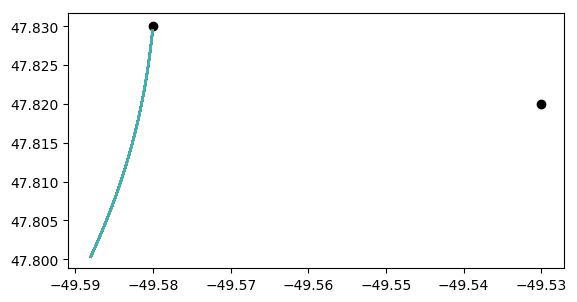

In [18]:
for berg in mod_berg_list:
    plt.plot(berg.history['X'], berg.history['Y'])
plt.scatter(iip_berg.history['X'], iip_berg.history['Y'], color='black')
plt.axis('scaled')
plt.savefig('plots/spaghetti_ind{}.png'.format(max_obs_berg_num))